In [ ]:
import os
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt


### 2. Object Twin (workload 3 students):
In this exercise, we will load a realsense-viewer rosbag recording, then use opencv and pyrender to create a twin of a moving checkerboard.
1. Loading color and depth data:
     * Use pyrealsense2 to read the bagfile and acquire color, depth, aligned depth to color, color camera intrinsics, depth camera intrinsics. (Show the images in a loop using `cv2.imshow`)
     
2. Checkerboard detection and tracking: 
     * The checkerboard has a `6x9` pattern where each square has an edge length of 4 cm.
     * Using opencv we want Find its corners (use `cv2.findChessboardCorners`, and `cv2.cornersSubPix`). then use `cv2.drawChessboardCorners` to overlay the detections on the colored image
     * From the previous step, you will have 2D/3D correspondences for the corners. Use `cv2.solvePnP` to estimate the object to camera translation and rotation vectors.
     * *Extra:* Use opencv drawing utils and perspective projection function to draw a 3D axis, and a cropping mask for the board. Useful functions here could be `cv2.line,cv2.projectPoints,cv2.fillPoly`.
3. Modeling the checkerboard in pyrender:
    * Using pyrender create a scene with camera and a `Box` mesh corresponding to the checkerboard.
    * Notes:
      1. You will need to scale the box and shift its center to match the checkerboard 3d coordinate system in opencv
      2. To convert from opencv camera to pyrender camera in you system you may need to rotate your objects by 90 degees around the X-axis (depending on your implementation) 
4. Visualization and Comparasion:
    * In the loop, update the mesh pose with the updated pose of the checkerboard
    * Compare the rendered depth value to the actual algined_depth values we got from realsense.
    * Optional: Report the Root Mean Squared Error RMSE between the rendered depth, and the actual depth within the detected area
a sample visualization could be seen in the figuire below
![image](assets/hw-1-2-example.png)

In [2]:
# Path to your .bag file
bag_file = "/workspace/NS1/01-Realsense/Homework/HW1-2-data/20220405_220626.bag"

# Create a pipeline
pipeline = rs.pipeline()

# Create a config object and configure it to use your recorded file
config = rs.config()
rs.config.enable_device_from_file(config, bag_file, repeat_playback=False)


In [3]:
def prepare_object_points(checkerboard_size, square_size):
    """
    Prepares 3D object points for the checkerboard in object coordinate system.
    
    Args:
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        square_size (float): Edge length of each square in meters.
    
    Returns:
        objp (np.ndarray): 3D points in object coordinate system (N x 3).
    """
    objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
    objp *= square_size
    return objp

def process_checkerboard(color_image, checkerboard_size, criteria):
    """
    Detects a checkerboard pattern in the given color image, refines corner locations, 
    and draws the detected corners on a copy of the input image.

    Args:
        color_image (np.ndarray): Input color image (RGB).
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        criteria: Termination criteria for cornerSubPix.

    Returns:
        color_for_draw (np.ndarray): Color image with overlaid detected corners (if found).
        found (bool): True if checkerboard is found, else False.
        corners2 (np.ndarray or None): Refined corner coordinates if found, else None.
    """
    # Convert color to grayscale for checkerboard detection
    gray = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

    # Try to find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    # Prepare the image for display (for matplotlib: needs RGBA)
    color_for_draw = color_image.copy()
    corners2 = None
    if found:
        # Refine corner locations
        corners2 = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria
        )
        # Draw the corners on the color image
        cv2.drawChessboardCorners(color_for_draw, checkerboard_size, corners2, found)

    return color_for_draw, found, corners2

def draw_3d_axis(image, rvec, tvec, camera_matrix, dist_coeffs, axis_length=0.1):
    """
    Draws 3D coordinate axes on the image using the pose estimation.
    
    Args:
        image (np.ndarray): Input image to draw on.
        rvec (np.ndarray): Rotation vector from solvePnP.
        tvec (np.ndarray): Translation vector from solvePnP.
        camera_matrix (np.ndarray): Camera intrinsic matrix.
        dist_coeffs (np.ndarray): Distortion coefficients.
        axis_length (float): Length of each axis in meters.
    
    Returns:
        image (np.ndarray): Image with drawn axes.
    """
    # Define 3D points for the axes (origin and three axis endpoints)
    axis_points = np.float32([
        [0, 0, 0],  # Origin
        [axis_length, 0, 0],  # X-axis (Red)
        [0, axis_length, 0],  # Y-axis (Green)
        [0, 0, axis_length]   # Z-axis (Blue)
    ]).reshape(-1, 3)
    
    # Project 3D points to 2D image plane
    imgpts, _ = cv2.projectPoints(axis_points, rvec, tvec, camera_matrix, dist_coeffs)
    imgpts = imgpts.reshape(-1, 2).astype(int)
    
    # Draw the axes
    origin = tuple(imgpts[0])
    image = cv2.line(image, origin, tuple(imgpts[1]), (255, 0, 0), 3)  # X-axis: Red
    image = cv2.line(image, origin, tuple(imgpts[2]), (0, 255, 0), 3)  # Y-axis: Green
    image = cv2.line(image, origin, tuple(imgpts[3]), (0, 0, 255), 3)  # Z-axis: Blue
    
    return image

def draw_board_mask(image, rvec, tvec, camera_matrix, dist_coeffs, checkerboard_size, square_size):
    """
    Draws a semi-transparent cropping mask for the checkerboard.
    
    Args:
        image (np.ndarray): Input image to draw on.
        rvec (np.ndarray): Rotation vector from solvePnP.
        tvec (np.ndarray): Translation vector from solvePnP.
        camera_matrix (np.ndarray): Camera intrinsic matrix.
        dist_coeffs (np.ndarray): Distortion coefficients.
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        square_size (float): Edge length of each square in meters.
    
    Returns:
        image (np.ndarray): Image with drawn mask.
    """
    # Define the 4 corner points of the board in 3D
    board_corners = np.float32([
        [0, 0, 0],
        [checkerboard_size[0] * square_size, 0, 0],
        [checkerboard_size[0] * square_size, checkerboard_size[1] * square_size, 0],
        [0, checkerboard_size[1] * square_size, 0]
    ]).reshape(-1, 3)
    
    # Project to 2D
    imgpts, _ = cv2.projectPoints(board_corners, rvec, tvec, camera_matrix, dist_coeffs)
    imgpts = imgpts.reshape(-1, 2).astype(int)
    
    # Create a semi-transparent overlay
    overlay = image.copy()
    cv2.fillPoly(overlay, [imgpts], (0, 255, 255))  # Yellow mask
    
    # Blend the overlay with the original image
    alpha = 0.3
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    
    # Draw the board outline
    cv2.polylines(image, [imgpts], True, (255, 0, 255), 2)  # Magenta outline
    
    return image

def display_images(color_image, depth_image, frame_count, fig, ax1, ax2):

    clear_output(wait=True)

    # Convert BGR to RGBA for matplotlib (cv2 uses RGB, so treat as such)
    color_rgba = cv2.cvtColor(color_image, cv2.COLOR_RGB2RGBA)
    depth_rgb = cv2.cvtColor(depth_image, cv2.COLOR_BGR2RGB)

    # Display images
    ax1.clear()
    ax1.imshow(color_rgba)
    ax1.set_title(f'Color Image (Frame {frame_count})')
    ax1.axis('off')

    ax2.clear()
    ax2.imshow(depth_rgb)
    ax2.set_title(f'Depth Image (Frame {frame_count})')
    ax2.axis('off')

    plt.tight_layout()
    display(fig)

    return


In [20]:
# Start pipeline with the config (no need to enable streams - they're auto-detected from bag file)
profile = pipeline.start(config)

# Get camera intrinsics from the color stream
color_stream = profile.get_stream(rs.stream.color)
color_intrinsics = color_stream.as_video_stream_profile().get_intrinsics()

# Build the camera matrix from intrinsics
camera_matrix = np.array([
    [color_intrinsics.fx, 0, color_intrinsics.ppx],
    [0, color_intrinsics.fy, color_intrinsics.ppy],
    [0, 0, 1]
], dtype=np.float32)

# Distortion coefficients (from RealSense intrinsics)
dist_coeffs = np.array(color_intrinsics.coeffs, dtype=np.float32)

print("Camera Intrinsics:")
print(f"Camera Matrix:\n{camera_matrix}")
print(f"Distortion Coefficients: {dist_coeffs}")


# Checkerboard settings
checkerboard_size = (6, 9)  # 6 rows, 9 columns (internal corners, not squares)
square_size = 0.04  # Each square is 4 cm = 0.04 meters

# Prepare 3D object points for the checkerboard
objp = prepare_object_points(checkerboard_size, square_size)

# This sets the stopping criteria for corner refinement using cv2.cornerSubPix: 
# stop either after 10 iterations or when the corner position changes by less than 0.001, 
# whichever comes first. Both accuracy (EPS) and max iterations are combined.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
pipeline.stop()


Camera Intrinsics:
Camera Matrix:
[[607.32263   0.      323.42648]
 [  0.      606.3023  249.37415]
 [  0.        0.        1.     ]]
Distortion Coefficients: [0. 0. 0. 0. 0.]


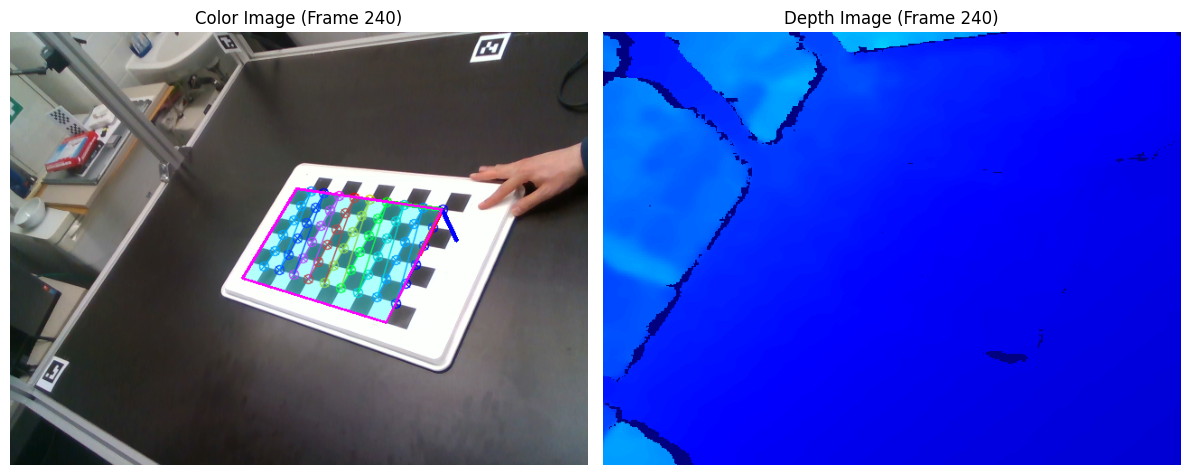


Processed 250 frames, checkerboard detection attempted on each.
Done!


In [21]:
# Start pipeline with the config (no need to enable streams - they're auto-detected from bag file)
profile = pipeline.start(config)

# Create figure for displaying images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Alignment (if you want aligned color and depth)
align = rs.align(rs.stream.color)
try:
    frame_count = 0
    max_frames = 250  # Limit frames to avoid too much output


    while frame_count < max_frames:
        # Wait for frames
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)

        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()

        if not color_frame or not depth_frame:
            print("End of bag file or no frames available")
            break

        # Convert images to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())
        # Normalize depth image for better visualization
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        image_with_corners, found, corners2 = process_checkerboard(color_image, checkerboard_size, criteria)

        # If checkerboard is found, estimate pose using solvePnP
        if found and corners2 is not None:
            # Solve PnP to get rotation and translation vectors
            success, rvec, tvec = cv2.solvePnP(
                objp, 
                corners2, 
                camera_matrix, 
                dist_coeffs
            )
            
            if success:
                # Draw 3D axis on the image
                image_with_corners = draw_3d_axis(image_with_corners, rvec, tvec, camera_matrix, dist_coeffs, axis_length=0.1)
                # Draw board mask
                image_with_corners = draw_board_mask(image_with_corners, rvec, tvec, camera_matrix, dist_coeffs, checkerboard_size, square_size)
                


        # Display every 10th frame to avoid too much output
        if frame_count % 10 == 0:
            display_images(image_with_corners, depth_colormap, frame_count, fig, ax1, ax2)
        frame_count += 1

    print(f"\nProcessed {frame_count} frames, checkerboard detection attempted on each.")

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
finally:
    pipeline.stop()
    plt.close()
    print("Done!")